In [205]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import curve_fit
import pandas as pd
from scipy.optimize import curve_fit
import ipywidgets as widgets
from ipywidgets import widgets, interactive, VBox, Button, FloatSlider, FloatText, interactive_output, link
from IPython.display import display, clear_output
import numpy as np
from ipywidgets import Checkbox

#from uncertainties import ufloat
#import uncertainties.unumpy as unp

In [206]:
path = 'calibration.csv'
df = pd.read_csv(path)

In [207]:
df.head()

,Time,minutes,corr_conc,recovery,std_corrconc,rec_std
0,2021-11-15 14:29:07,0,0.0,0.0,0.0,0.0
1,2021-11-15 14:31:07,2,0.0,0.0,0.0,0.0
2,2021-11-15 14:33:07,4,0.0,0.0,0.0,0.0
3,2021-11-15 14:35:07,6,0.0,0.0,0.0,0.0
4,2021-11-15 14:37:07,8,0.0,0.0,0.0,0.0


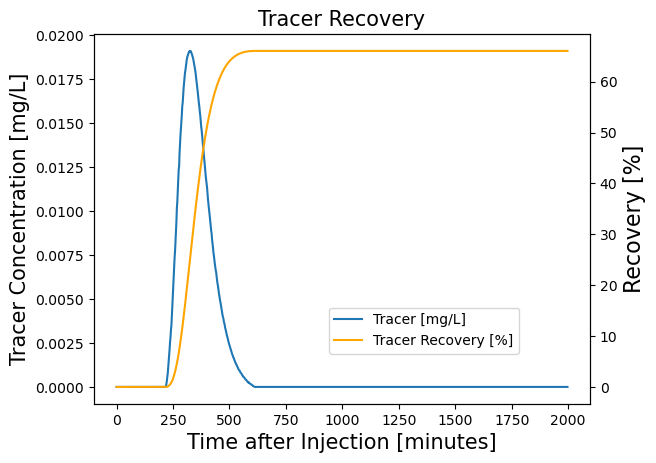

In [208]:
df = pd.read_csv('calibration.csv')

# plot df['corr_conc]
fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.plot(df['minutes'], df['corr_conc'])
ax2.plot(df['minutes'], df['recovery'], color = 'orange')

ax.set_title("Tracer Recovery", fontsize=15)

ax.set_ylabel("Tracer Concentration [mg/L]", fontsize=(15))
ax.set_xlabel("Time after Injection [minutes]", fontsize=(15))
ax2.set_ylabel("Recovery [%]", fontsize=16)

fig.legend(['Tracer [mg/L]', 'Tracer Recovery [%]'], loc = 'lower right', bbox_to_anchor=(0.8, 0.2))



In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from ipywidgets import widgets, interactive, VBox, Button, FloatSlider, FloatText, Checkbox
from IPython.display import display, clear_output


class OneDimensionalAdvectionDispersionModel:
    """
    A class representing a one-dimensional advection dispersion model.

    Attributes:
        real_data_file (str): The file path to the real data file.
        x (float): Distance (m).
        m_in (float): Mass input rate (g).
        Q (float): Flow rate (m^3/s).
        popt (ndarray): Optimal parameters after fitting.
        pcov (ndarray): Covariance of popt.
        fitted_line (ndarray): Placeholder for the fitted line.
        model_line (ndarray): Placeholder for the model line.

    Methods:
        return_real_data(): Returns the real data.
        return_manual_adjusted_model(): Returns the manually adjusted model line.
        return_fitted_model(): Returns the fitted model line.
        diff_fit(t, D, v, Q=None, m_in=None, x=None): Calculates the concentration values based on the given parameters.
        initial_plot(): Initializes the plot with real data.
        fit_model(p0, bounds, fit_m_in=False): Fits the model to the real data.
        plot_with_model(D, v, Q, m_in, x, fit_m_in=False): Plots the real data, manual fit, and automatic fit.
        create_interactive_plot(): Creates an interactive plot for adjusting the model parameters.
    """

    def __init__(self, real_data_file, x=300, m_in=2.05, Q=11e-3):
        """
        Initializes a OneDimensionalAdvectionDispersionModel object.

        Args:
            real_data_file (str): The file path to the real data file.
            x (float, optional): Distance (m). Defaults to 300.
            m_in (float, optional): Mass input rate (g). Defaults to 2.05.
            Q (float, optional): Flow rate (m^3/s). Defaults to 11e-3.
        """
        self.real_data = pd.read_csv(real_data_file)
        self.real_data['seconds'] = self.real_data['minutes'] * 60  # Convert minutes to seconds
        self.x = x
        self.m_in = m_in
        self.Q = Q
        self.popt = None
        self.pcov = None
        self.fitted_line = None
        self.model_line = None

    def return_real_data(self):
        """
        Returns the real data.

        Returns:
            DataFrame: The real data.
        """
        return self.real_data
    
    def return_manual_adjusted_model(self):
        """
        Returns the manually adjusted model line.

        Returns:
            ndarray: The manually adjusted model line.
        """
        return self.manual_model_line

    def return_fitted_model(self):
        """
        Returns the fitted model line.

        Returns:
            ndarray: The fitted model line.
        """
        return self.auto_model_line

    def diff_fit(self, t, D, v, Q=None, m_in=None, x=None):
        """
        Calculates the concentration values based on the given parameters.

        Args:
            t (ndarray): Time values.
            D (float): Dispersion coefficient.
            v (float): Velocity.
            Q (float, optional): Flow rate (m^3/s). Defaults to None.
            m_in (float, optional): Mass input rate (g). Defaults to None.
            x (float, optional): Distance (m). Defaults to None.

        Returns:
            ndarray: The calculated concentration values.
        """
        if Q is None:
            Q = self.Q
        if m_in is None:
            m_in = self.m_in
        if x is None:
            x = self.x

        term1 = m_in / Q
        term2 = x / (np.sqrt(4 * np.pi * D * t**3) + 1e-10)
        return term1 * term2 * np.exp(-((x - v * t)**2) / ((4 * D * t) + 1e-10))

    def initial_plot(self):
        """
        Initializes the plot with real data.
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        self.fig = fig
        self.ax = ax
        ax.plot(self.real_data['seconds'], self.real_data['corr_conc'], label='Real Data (Concentration)', color='orange')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Concentration')
        ax.set_title('Concentration vs. Time')
        plt.legend()
        plt.close()

        self.fixed_x_range = (self.real_data['seconds'].min(), self.real_data['seconds'].max()*1.2)
        self.fixed_y_range = (self.real_data['corr_conc'].min(), self.real_data['corr_conc'].max()*1.2)

    def fit_model(self, fit_m_in=False):
        """
        Fits the model to the real data.

        Args:
            p0 (str): Initial guess for the parameters.
            bounds (str): Bounds for the parameters.
            fit_m_in (bool, optional): Whether to fit the mass input rate (m_in). Defaults to False.
        """
        t = self.real_data['seconds'].values
        conc = self.real_data['corr_conc'].values

        # check if input mass should be fitted
        if fit_m_in:

            # assign slider values to p0 for initial guess
            p0 = self.D, self.v, self.m_in
            print('initial guess for D, v, m_in: ', p0)
            self.popt, self.pcov = curve_fit(lambda t, D, v, m_in: self.diff_fit(t=t, D=D, v=v, m_in=m_in), t, conc, p0=p0)
        else:
            # assign slider values to p0 for initial guess
            p0 = self.D, self.v
            self.popt, self.pcov = curve_fit(lambda t, D, v: self.diff_fit(t, D, v), t, conc, p0=p0)
        print(f"Fitted parameters: D = {self.popt[0]:.3f}, v = {self.popt[1]:.3f}" + (f", m_in = {self.popt[2]:.3f}" if fit_m_in else ""))

    def plot_with_model(self, D, v, Q, m_in, x, fit_m_in=False):
        """
        Plots the real data, manual fit, and automatic fit.

        Args:
            D (float): Dispersion coefficient.
            v (float): Velocity.
            Q (float): Flow rate (m^3/s).
            m_in (float): Mass input rate (g).
            x (float): Distance (m).
            fit_m_in (bool, optional): Whether to fit the mass input rate (m_in). Defaults to False.
        """
        clear_output(wait=True)
        self.ax.clear()
        plt.close()

        seconds = self.real_data['seconds'].values
        t_values = np.linspace(seconds.min(), seconds.max(), 1000)
        c_values = self.diff_fit(t_values, D, v, Q, m_in, x)

        self.ax.plot(self.real_data['seconds'], self.real_data['corr_conc'], label='Data (Concentration)', color='orange')
        self.ax.plot(t_values, c_values, label=f"Manual Fit (D: {D:.3f}, v: {v:.3f})", color='blue')

        if self.popt is not None:
            D = self.popt[0]
            v = self.popt[1]
            if fit_m_in:
                m_in = self.popt[2]
            else: 
                m_in = None

            fitted_values = self.diff_fit(t_values, D=D, v=v, m_in=m_in)
            legend_label = f"Automatic Fit (D: {self.popt[0]:.3f}, v: {self.popt[1]:.3f}"
            if fit_m_in:
                legend_label += f", m_in: {self.popt[2]:.3f}"
            legend_label += ")"
            self.ax.plot(t_values, fitted_values, label=legend_label, color='red')
            self.auto_model_line = fitted_values

        Dispersivity = D/v
        self.ax.text(0.92, 0.87, f'Dispersivity  : {Dispersivity:.3f} m/s', transform=plt.gcf().transFigure, fontsize=12, verticalalignment='bottom')

        self.ax.set_xlim(self.fixed_x_range)
        self.ax.set_ylim(self.fixed_y_range)
        self.ax.set_xlabel('Time (seconds)')
        self.ax.set_ylabel('Concentration')
        self.ax.set_title('1D Advection Dispersion Model')
        self.ax.legend()
        
        display(self.fig)

        self.manual_model_line = c_values
        self.t_values = t_values

    def create_interactive_plot(self):
        """
        Creates an interactive plot for adjusting the model parameters.
        """
        D_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.0005, description='D [m^2/s]:', readout_format='.3f')
        v_slider = widgets.FloatSlider(value=1, min=0, max=0.09, step=0.00005, description='v [m/s]:', readout_format='.3f')
        Q_slider = FloatSlider(value=self.Q, min=0.001, max=0.02, step=0.001, description='Q [m^3/s]:', readout_format='.4f')
        m_in_slider = FloatSlider(value=self.m_in, min=1, max=3, step=0.05, description='m_in [g]:', readout_format='.2f')
        x_slider = FloatSlider(value=self.x, min=100, max=1500, step=10, description=' x :', readout_format='.0f')
        fit_m_checkbox = Checkbox(value=False, description='Fit Mass Input Rate (m_in)')
        xmin_text = FloatText(value=self.fixed_x_range[0], description='Xmin:')
        xmax_text = FloatText(value=self.fixed_x_range[1], description='Xmax:')
        #p0_text = widgets.Text(value="(0.1, 1)", description="Initial Guess (p0):")
        bounds_text = widgets.Text(value="(0, [np.inf, np.inf])", description="Bounds:")
        fit_button = Button(description="Fit Model")

        def update_plot(D, v, Q, m_in, x, xmin, xmax):
            self.fixed_x_range = (xmin, xmax)
            self.plot_with_model(D, v, Q, m_in, x, fit_m_in=fit_m_checkbox.value)

            self.D = D
            self.v = v
            self.m_in = m_in

        def on_fit_button_clicked(b):

            self.fit_model(fit_m_in=fit_m_checkbox.value)
            update_plot(D_slider.value, v_slider.value, Q_slider.value, m_in_slider.value, x_slider.value, xmin_text.value, xmax_text.value)

        fit_button.on_click(on_fit_button_clicked)

        interactive_plot = interactive(update_plot, 
                                       D=D_slider, 
                                       v=v_slider, 
                                       Q=Q_slider, 
                                       m_in=m_in_slider, 
                                       x=x_slider, 
                                       xmin=xmin_text, 
                                       xmax=xmax_text)

        display(VBox([fit_m_checkbox, fit_button, interactive_plot]))

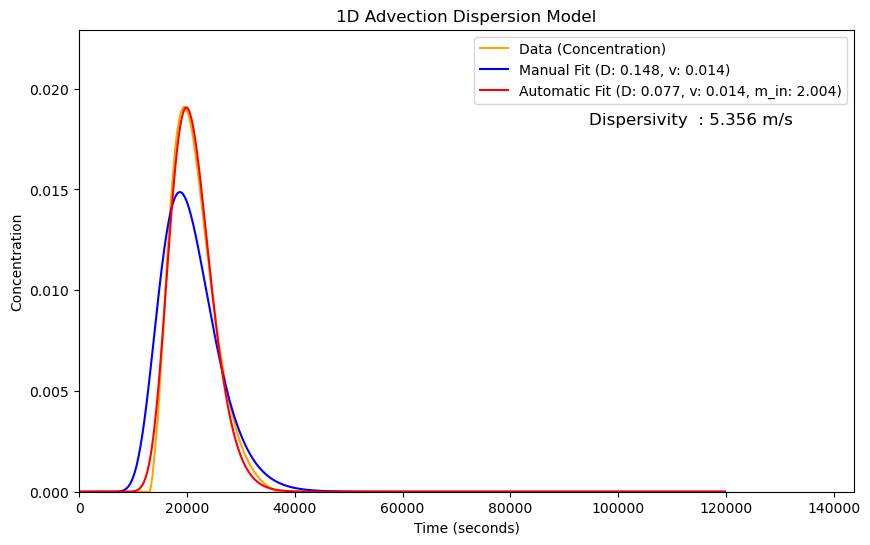

<Figure size 640x480 with 0 Axes>

In [210]:
path_to_data = 'calibration.csv'

# Parameter Eingabe (kann nachher noch geändert werden)
distance = 300  # m
mass_input_rate = 2.05  # g
flow_rate = 11e-3  # m^3/s

model = OneDimensionalAdvectionDispersionModel(path_to_data, x=distance, m_in=mass_input_rate, Q=flow_rate)
model.initial_plot()
model.create_interactive_plot()

Direkt nachdem man auf den fit_model button geclickt hat ist der plot nicht mehr interaktiv. Anschließend kann man die nächsten Zellen laufen lassen undsich ansehen wie gut der 
manuelle fit im vergleich zu dem automatischen fit ist. Die automatische Fitting methode benötigt jedenfalls einen initial guess der nicht zu weit vom wahren wert entfernt ist damit das ganze halbwegs gut funktioniert. 

In [211]:
manual_adjusted_model = model.return_manual_adjusted_model()
fitted_model = model.return_fitted_model()
real_data= model.return_real_data()

AttributeError: 'OneDimensionalAdvectionDispersionModel' object has no attribute 'auto_model_line'

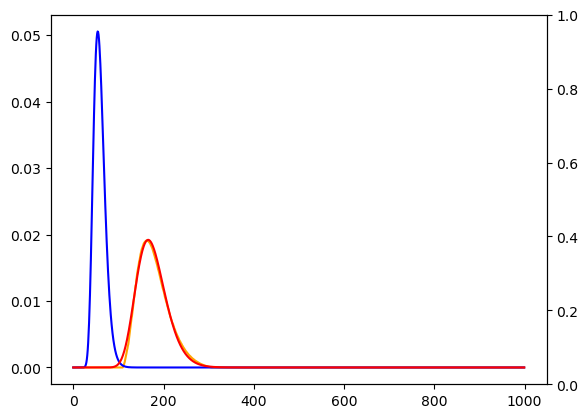

In [ ]:
# plot 
fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.plot(real_data['corr_conc'], color ='orange')
ax.plot(manual_adjusted_model, color = 'blue')
ax.plot(fitted_model, color = 'red')

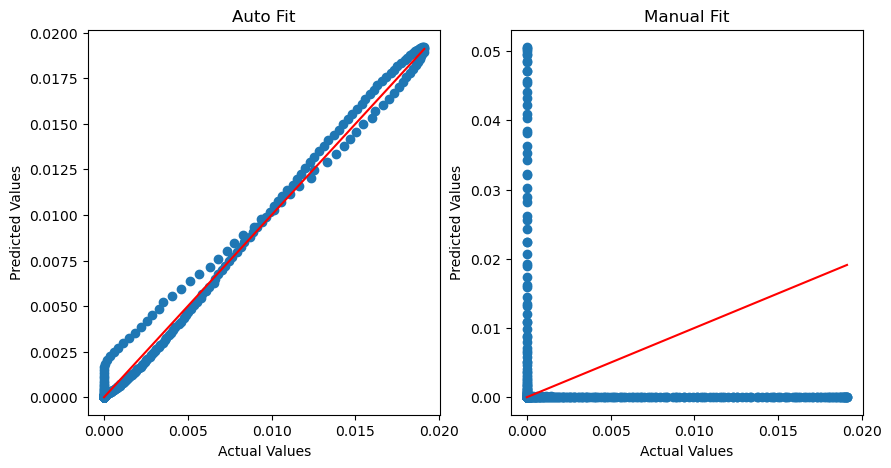

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have two lists: y_actual and y_predicted for both auto and manual fit
y_actual = real_data['corr_conc']
y_predicted_auto = fitted_model
y_predicted_manual = manual_adjusted_model

plt.figure(figsize=(10, 5))

# Plot for auto fit
plt.subplot(1, 2, 1)
plt.scatter(y_actual, y_predicted_auto)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Auto Fit')
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red') # 45 degree line

# Plot for manual fit
plt.subplot(1, 2, 2)
plt.scatter(y_actual, y_predicted_manual)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Manual Fit')
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red') # 45 degree line

plt.show()

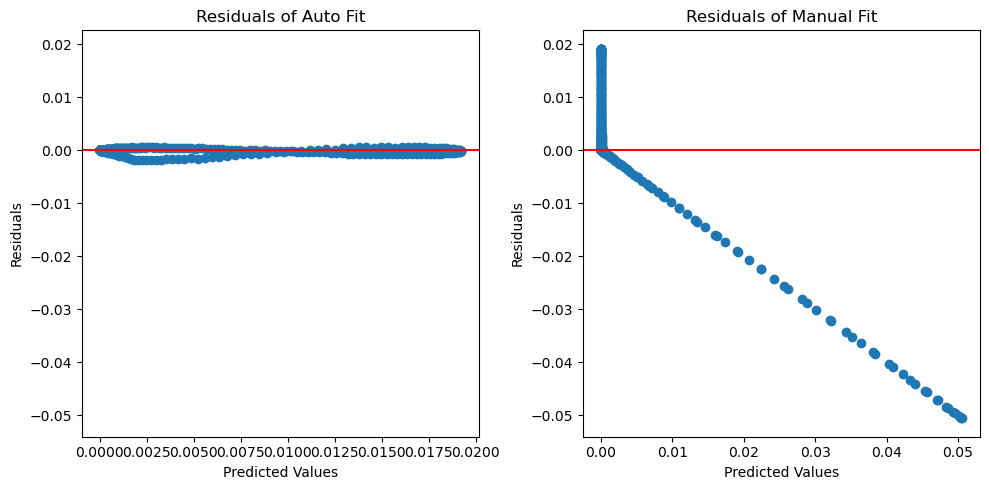

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals for auto and manual fit
residuals_auto = [actual - predicted for actual, predicted in zip(y_actual, y_predicted_auto)]
residuals_manual = [actual - predicted for actual, predicted in zip(y_actual, y_predicted_manual)]

plt.figure(figsize=(10, 5))

# Residual plot for auto fit
plt.subplot(1, 2, 1)
plt.scatter(y_predicted_auto, residuals_auto)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals of Auto Fit')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Residual plot for manual fit
plt.subplot(1, 2, 2, sharey=plt.gca())
plt.scatter(y_predicted_manual, residuals_manual)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals of Manual Fit')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()